In [1]:
from time import sleep
import pandas as pd
from  selenium import webdriver
import mylib
import numpy as  np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize': [15, 10]}, font_scale=1.2)
from datasist.structdata import detect_outliers
from bs4 import BeautifulSoup as bs
import  requests

In [3]:
df=mylib.Describe.describeDf('../DataSet/Data_Train.xlsx')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None
              Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000


In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


Airline
['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']
********************************************************************************


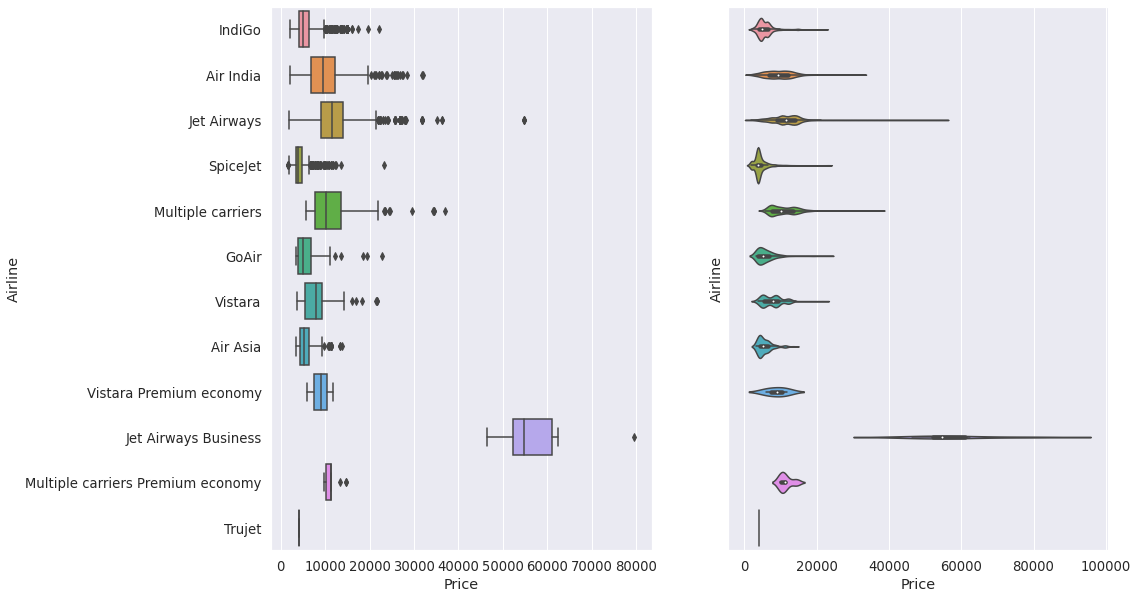

                                    Mean  Median
Airline                                         
Air Asia                            5590    5162
Air India                           9611    9443
GoAir                               5861    5135
IndiGo                              5673    5000
Jet Airways                        11643   11467
Jet Airways Business               58358   54747
Multiple carriers                  10902   10197
Multiple carriers Premium economy  11418   11269
SpiceJet                            4338    3873
Trujet                              4140    4140
Vistara                             7796    7980
Vistara Premium economy             8962    9125


In [5]:
from mylib import  Visualization
mylib.Describe.allUnique(df,['Airline'])
Visualization.catsStatistics(df,['Airline'],'Price')

6


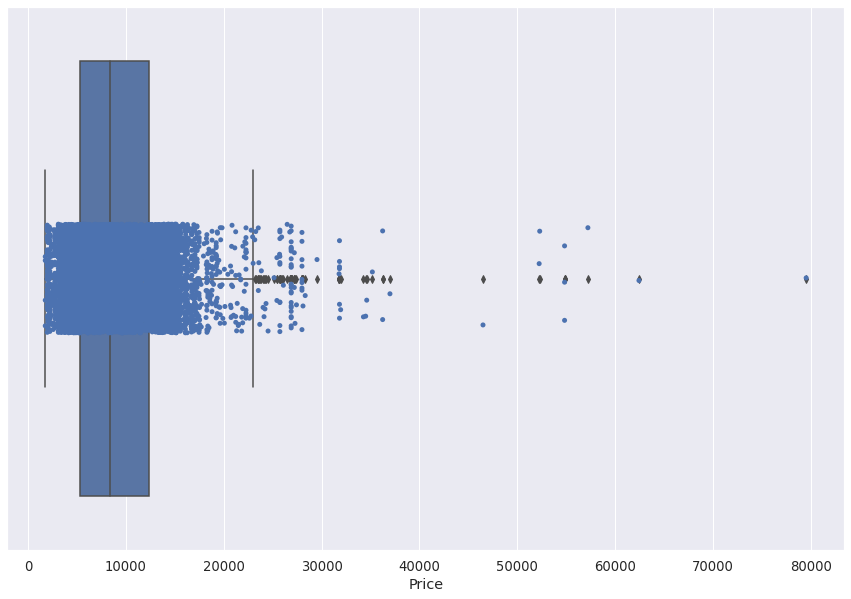

/home/xcrown/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


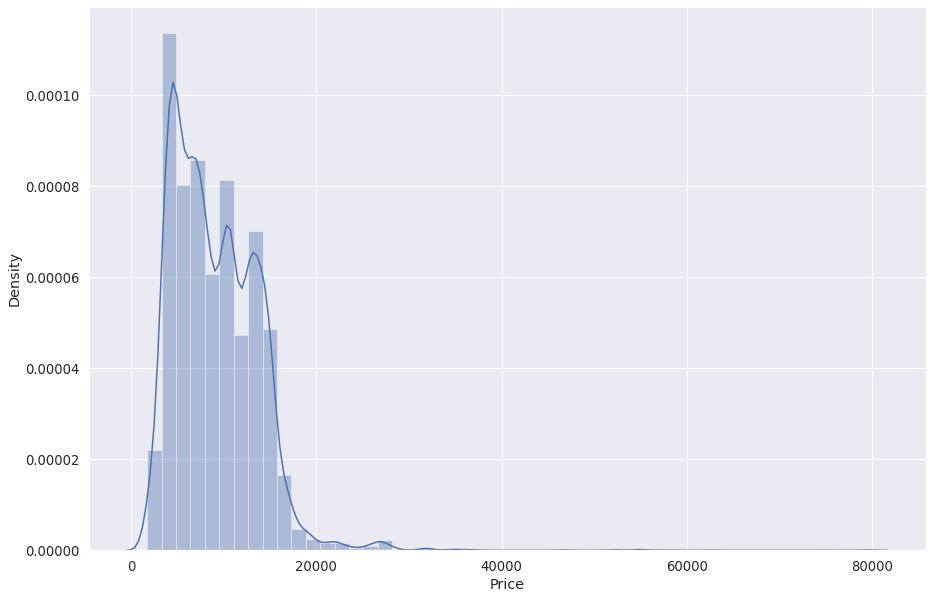

In [6]:
print(df[df['Airline']=='Jet Airways Business'].count()[1])
Visualization.printOutlier(df,'Price')

In [7]:
df.drop(df[df['Airline']=='Jet Airways Business'].index,axis=0,inplace=True)

In [8]:
idx = ["Price"]
outliers_indices = detect_outliers(df, 0, idx)
df.drop(outliers_indices,inplace=True,axis=0)
len(outliers_indices)

88

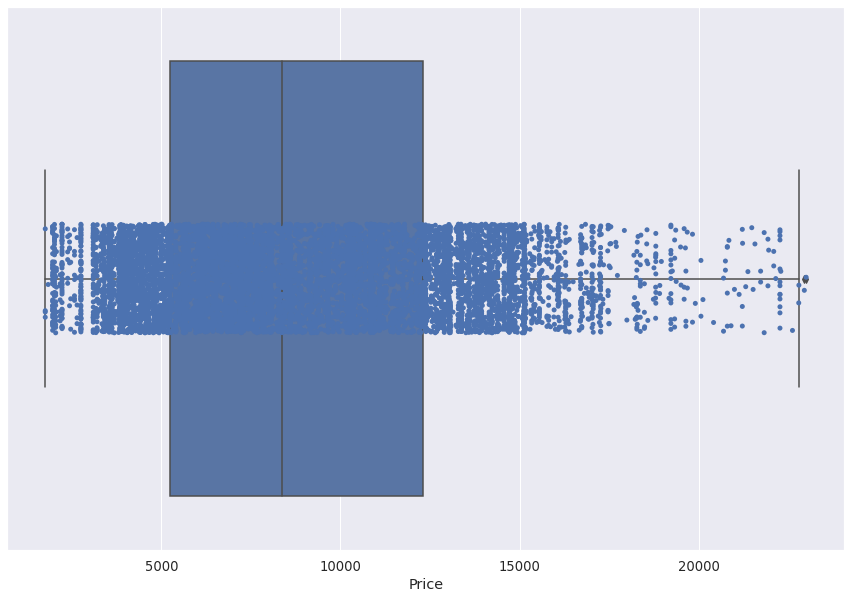

/home/xcrown/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


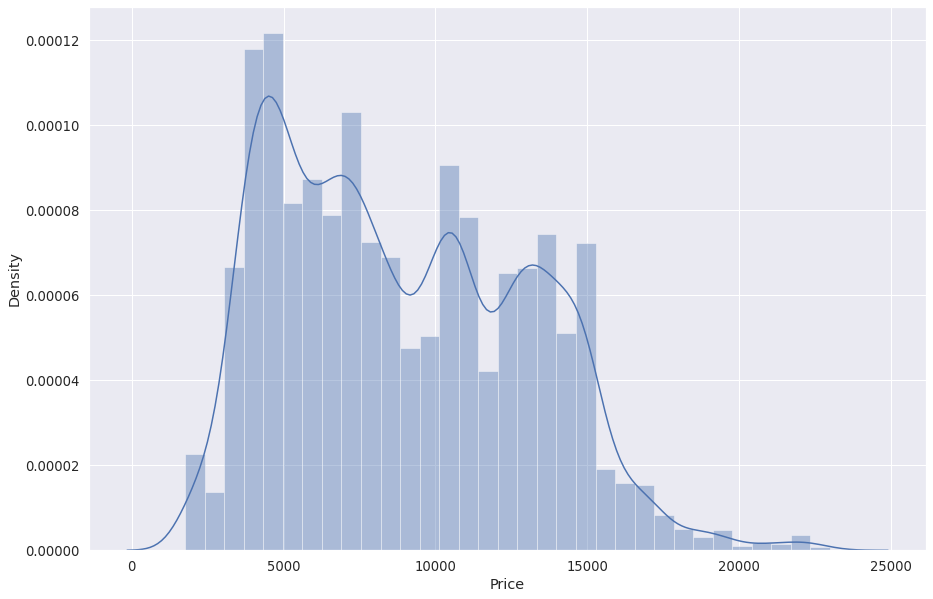

In [9]:
Visualization.printOutlier(df,'Price')

Airline
['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy'
 'Multiple carriers Premium economy' 'Trujet']
********************************************************************************


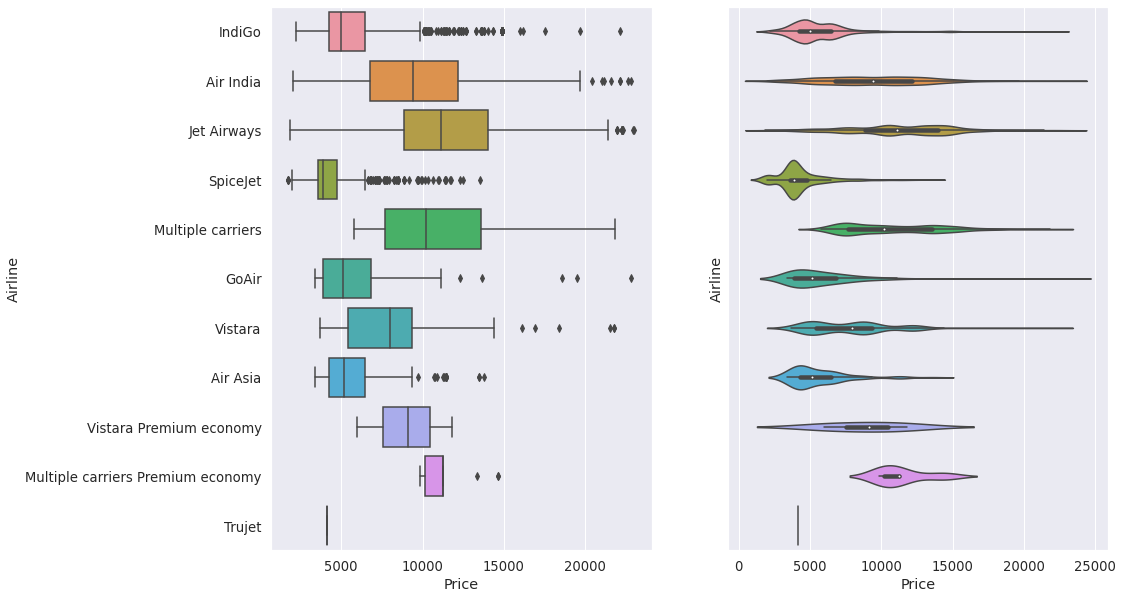

                                    Mean  Median
Airline                                         
Air Asia                            5590    5162
Air India                           9463    9417
GoAir                               5861    5135
IndiGo                              5673    5000
Jet Airways                        11360   11134
Multiple carriers                  10750   10197
Multiple carriers Premium economy  11418   11269
SpiceJet                            4315    3873
Trujet                              4140    4140
Vistara                             7796    7980
Vistara Premium economy             8962    9125


In [10]:
from mylib import  Visualization
mylib.Describe.allUnique(df,['Airline'])
Visualization.catsStatistics(df,['Airline'],'Price')

In [11]:
arw=df['Route'].unique()[1][4]
df['Route']=df['Route'].apply(  lambda x : ('/'.join([i for i in x.split(arw)]).replace(" ", "")if(type(x)!=float) else'') )

In [12]:
df['Route']

0                BLR/DEL
1        CCU/IXR/BBI/BLR
2        DEL/LKO/BOM/COK
3            CCU/NAG/BLR
4            BLR/NAG/DEL
              ...       
10678            CCU/BLR
10679            CCU/BLR
10680            BLR/DEL
10681            BLR/DEL
10682    DEL/GOI/BOM/COK
Name: Route, Length: 10589, dtype: object

In [13]:
from  joblib import load
pagesrc =load('Routs_objects.h5')

In [14]:
Distance={}
for i in pagesrc :
        soup=bs(i,'html.parser')
        value=soup.find('span',class_='value km')
        index=soup.find('a',class_='main-route trip')
        if value is None and index is None:
            continue
        Distance.update({index['href'][1:]: ''.join([i for i in value.text if i!=','])})

In [15]:
df['Distance']=df['Route'].map(Distance)
df['Distance']=df['Distance'].astype(float)